# Transfer Learning with Keras
## Using  Files

(C) 2019 Umberto Michelucci

www.toelt.ai

Reference: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [0]:
import numpy as np
import os
import shutil
import glob

np.random.seed(42)

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

## Load the data

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes. [Source of the next few cells: google]

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-09-11 15:04:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   152MB/s    in 0.4s    

2019-09-11 15:04:19 (152 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
!ls /tmp

cats_and_dogs_filtered	cats_and_dogs_filtered.zip


The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets , which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [0]:
!ls /tmp/cats_and_dogs_filtered/train

cats  dogs


In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:10])


validation_cat_fnames = os.listdir(validation_cats_dir)


validation_dog_fnames = os.listdir(validation_dogs_dir)

['cat.949.jpg', 'cat.388.jpg', 'cat.308.jpg', 'cat.881.jpg', 'cat.193.jpg', 'cat.51.jpg', 'cat.653.jpg', 'cat.89.jpg', 'cat.398.jpg', 'cat.470.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [0]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [0]:
cat_train = os.listdir(train_cats_dir)
dog_train = os.listdir(train_dogs_dir)
cat_val = os.listdir(validation_cats_dir)
dog_val = os.listdir(validation_dogs_dir)

# Example: let's print the name of some of the files
print(cat_train[0:3])

['cat.949.jpg', 'cat.388.jpg', 'cat.308.jpg']


In [0]:
train_files = np.concatenate([[train_dogs_dir+'/' + x for x in train_dog_fnames],
                              [train_cats_dir+'/' + x for x in train_cat_fnames]])

validation_files = np.concatenate([[validation_dogs_dir+'/' + x for x in validation_dog_fnames],
                              [validation_cats_dir+'/' + x for x in validation_cat_fnames]])

In [0]:
print(train_files.shape)
print(validation_files.shape)

(2000,)
(1000,)


In [0]:
train_files[0:3]

array(['/tmp/cats_and_dogs_filtered/train/dogs/dog.0.jpg',
       '/tmp/cats_and_dogs_filtered/train/dogs/dog.1.jpg',
       '/tmp/cats_and_dogs_filtered/train/dogs/dog.10.jpg'], dtype='<U50')

In [0]:
train_dir = '/tmp/tr/'
validation_dir = '/tmp/va/'

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(validation_dir) if not os.path.isdir(validation_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validation_files:
    shutil.copy(fn, validation_dir)

Let's now read the files

In [0]:
IMG_DIM = (150, 150)

train_files = glob.glob(train_dir + '/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[3].split('.')[0].strip() for fn in train_files]
# MAC '/', WINDOWS '\\'

validation_files = glob.glob(validation_dir + '/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[3].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (2000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [0]:
train_labels[0:3]

['dog', 'dog', 'cat']

(150, 150, 3)


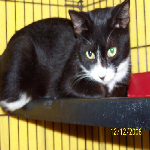

In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[3].shape)
array_to_img(train_imgs[3])

In [0]:
batch_size = 30
num_classes = 2
epochs = 10
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[10:15], train_labels_enc[10:15])

['dog', 'dog', 'cat', 'cat', 'dog'] [1 1 0 0 1]


# CNN Model

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
__________________________________________

In [0]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6420 - acc: 0.6700 - val_loss: 0.7042 - val_acc: 0.6090
Epoch 2/10
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.5407 - acc: 0.7245 - val_loss: 0.7313 - val_acc: 0.5890
Epoch 3/10
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.4655 - acc: 0.7810 - val_loss: 0.8077 - val_acc: 0.6620
Epoch 4/10
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.3816 - acc: 0.8280 - val_loss: 0.7899 - val_acc: 0.6960
Epoch 5/10
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.3038 - acc: 0.8710 - val_loss: 0.6968 - val_acc: 0.7430
Epoch 6/10
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.2142 - acc: 0.9165 - val_loss: 1.1172 - val_acc: 0.6500
Epoch 7/10
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.1461 - acc: 0.9495 - val_loss: 1.1495 - val_acc: 0.7190


Note that we are extremly overfitting here! Check how the training accuracy is almost 100% while the validation accuracy is around 73%. Overfitting is typically one of the main problems when training big neural networks.

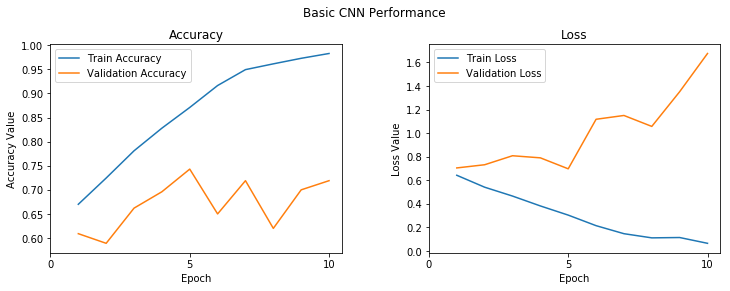

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,10+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 10+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
input_shape = (150, 150, 3)

In [0]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras as keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

58892288/58889256 [==============================] - 1s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f61b04f5630>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f61b04f5710>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f61b03f17b8>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f61b03bc2b0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f61b03bcba8>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f61b03665f8>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f61b0311710>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f61b0311f60>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f61b033fa58>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f61b02e4b70>,block3_conv3,False


(1, 4, 4, 512)


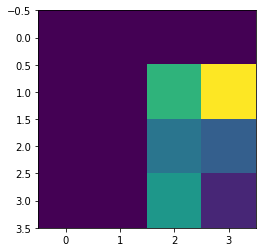

In [0]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

As you may notice all parameters are still trainable. We need to correct this.

In [0]:
%%time
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (2000, 8192) 	Validation Bottleneck Features: (1000, 8192)
CPU times: user 12.5 s, sys: 6.54 s, total: 19.1 s
Wall time: 17.9 s


In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr =1e-4),
              #optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 1s 378us/sample - loss: 0.4788 - acc: 0.7530 - val_loss: 0.3355 - val_acc: 0.8510
Epoch 2/10
2000/2000 [==============================] - 1s 289us/sample - loss: 0.2869 - acc: 0.8755 - val_loss: 0.2705 - val_acc: 0.8760
Epoch 3/10
2000/2000 [==============================] - 1s 298us/sample - loss: 0.2195 - acc: 0.9095 - val_loss: 0.3026 - val_acc: 0.8780
Epoch 4/10
2000/2000 [==============================] - 1s 292us/sample - loss: 0.1776 - acc: 0.9325 - val_loss: 0.2612 - val_acc: 0.8860
Epoch 5/10
2000/2000 [==============================] - 1s 285us/sample - loss: 0.1546 - acc: 0.9380 - val_loss: 0.2872 - val_acc: 0.8830
Epoch 6/10
2000/2000 [==============================] - 1s 294us/sample - loss: 0.1097 - acc: 0.9580 - val_loss: 0.2795 - val_acc: 0.8820
Epoch 7/10
2000/2000 [==============================] - 1s 287us/sample - loss: 0.0971 - acc: 0.9590 - val_loss: 0.2756 - va

# Create a complete network and use it for training

In [0]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [0]:
base_model=VGG16(include_top=False, weights='imagenet') #imports the VGG16 model and discards the last layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [0]:
model=Model(inputs=base_model.input,outputs=preds)

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [0]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [0]:
len(model.layers)

22

In [0]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [0]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                        validation_data=(validation_imgs_scaled, validation_labels_enc),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1)

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 15s 8ms/sample - loss: 0.1522 - acc: 0.9345 - val_loss: 0.3089 - val_acc: 0.8850
Epoch 2/10
2000/2000 [==============================] - 15s 8ms/sample - loss: 0.1181 - acc: 0.9530 - val_loss: 0.3306 - val_acc: 0.8770
Epoch 3/10
2000/2000 [==============================] - 15s 8ms/sample - loss: 0.1097 - acc: 0.9570 - val_loss: 0.3075 - val_acc: 0.8930
Epoch 4/10
2000/2000 [==============================] - 15s 8ms/sample - loss: 0.0940 - acc: 0.9675 - val_loss: 0.3342 - val_acc: 0.8790
Epoch 5/10
2000/2000 [==============================] - 15s 8ms/sample - loss: 0.0877 - acc: 0.9685 - val_loss: 0.4740 - val_acc: 0.8290
Epoch 6/10
2000/2000 [==============================] - 15s 8ms/sample - loss: 0.1026 - acc: 0.9570 - val_loss: 0.3543 - val_acc: 0.8730
Epoch 7/10
2000/2000 [==============================] - 15s 8ms/sample - loss: 0.0699 - acc: 0.9775 - val_loss: 0.3387 - val_acc: 

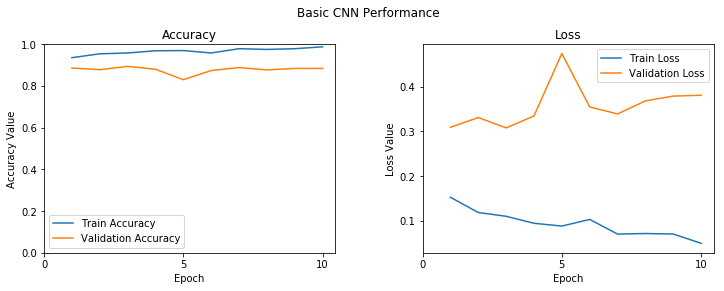

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,10+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 10+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.set_ylim(0,1)
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax1.set_ylim(0,1)
l2 = ax2.legend(loc="best")